In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set_style('ticks')

INPUT = "./input/"
OUTPUT = "./output/"

os.makedirs(OUTPUT, exist_ok=True)

train = pd.read_csv(os.path.join(INPUT, "train.csv"))
test = pd.read_csv(os.path.join(INPUT, "test.csv"))
whole_df = pd.concat([train, test], ignore_index=True)

In [2]:
def preprocess(input_df: pd.DataFrame) -> pd.DataFrame:
    output_df = input_df.copy()

    idx_tbd = input_df['User_Score'] == 'tbd'
    output_df['User_Score_is_tbd'] = idx_tbd.astype(int)

    output_df['User_Score'] = input_df['User_Score'].replace('tbd', None).astype(float)
    return output_df

def create_continuous_features(input_df):
    input_df = preprocess(input_df)
    use_columns = [
        # 連続変数
        'Critic_Score',
        'Critic_Count', 
        'User_Score', 
        'User_Count',
        'Year_of_Release',
        'User_Score_is_tbd'
    ]
    return input_df[use_columns].copy()

In [3]:
def create_boolean_feature(input_df):
    output_df = pd.DataFrame()

    texts = [
        'japan', 'nintendo'
    ]

    for t in texts:
        output_df[f'Developer_has_{t}'] = input_df['Developer'].fillna('').str.lower().str.contains(t).astype(int)
    return output_df

In [4]:
class BaseBlock(object):
    def fit(self, input_df, y=None):
        return self.transform(input_df)
    def transform(self, input_df):
        raise NotImplementedError()

In [5]:
_df = train.groupby("Name")["Platform"].count()
pd.merge(train["Name"], _df, on="Name", how="left").values[:, 1]

array([7, 4, 7, ..., 1, 2, 2], dtype=object)

In [6]:
vc = train["Name"].value_counts()
train["Name"].map(vc).values

array([7, 4, 7, ..., 1, 2, 2])

In [7]:
class CountEncodingBlock(BaseBlock):
    def __init__(self, column, whole_df: pd.DataFrame):
        self.column = column
        self.whole_df = whole_df
        
    def transform(self, input_df):
        output_df = pd.DataFrame()
        c = self.column
        
        vc = self.whole_df[c].value_counts()
        output_df[c] = input_df[c].map(vc)
        return output_df.add_prefix("CE_")


In [8]:
assert len(train) == len(CountEncodingBlock("Name", whole_df=whole_df).fit(train))

In [9]:
class OneHotBlock(BaseBlock):
    def __init__(self, column: str):
        self.column = column
        self.cats_ = None
        
    def fit(self, input_df, y=None):
        vc = input_df[self.column].dropna().value_counts()
        cats = vc[vc > 40].index
        self.cats_ = cats
        return self.transform(input_df)
    
    def transform(self, input_df):
        x = pd.Categorical(input_df[self.column], categories=self.cats_)
        out_df = pd.get_dummies(x, dummy_na=False)
        out_df.columns = out_df.columns.tolist()
        return out_df.add_prefix(f"OH_{self.column}=")

In [10]:
OneHotBlock("Platform").fit(train).sum(axis=0)

OH_Platform=DS      1106
OH_Platform=PS2     1104
OH_Platform=Wii      645
OH_Platform=PS3      643
OH_Platform=PSP      642
OH_Platform=X360     588
OH_Platform=PS       512
OH_Platform=GBA      445
OH_Platform=PC       439
OH_Platform=XB       371
OH_Platform=3DS      270
OH_Platform=GC       240
OH_Platform=PSV      240
OH_Platform=PS4      206
OH_Platform=SNES     130
OH_Platform=SAT      129
OH_Platform=N64      125
OH_Platform=XOne     121
OH_Platform=2600      88
OH_Platform=WiiU      87
OH_Platform=GB        78
OH_Platform=NES       66
OH_Platform=DC        41
dtype: int64

In [11]:
from textdistance import jaro

In [12]:
jaro("foo", "f09")

0.5555555555555555

In [13]:
query = train["Name"].values[100]
query

'Frogs And Flies'

In [14]:
results = train["Name"].map(lambda x: jaro(query, x))
train["Name"][results > .8]

100    Frogs And Flies
Name: Name, dtype: object

In [15]:
import texthero as hero
from texthero import preprocessing

In [16]:
custom_pipeline = [
    preprocessing.fillna,
    preprocessing.lowercase,
    preprocessing.remove_digits,
    preprocessing.remove_punctuation,
    preprocessing.remove_diacritics,
    preprocessing.remove_whitespace,
    preprocessing.remove_stopwords
]

In [17]:
names = hero.clean(whole_df["Name"], custom_pipeline)

/opt/anaconda3/lib/python3.7/site-packages/texthero/preprocessing.py:72: FutureWarning: The default value of regex will change from True to False in a future version.
  return input.str.replace(pattern, symbols)
/opt/anaconda3/lib/python3.7/site-packages/texthero/preprocessing.py:131: FutureWarning: The default value of regex will change from True to False in a future version.
  return input.str.replace(rf"([{string.punctuation}])+", symbol)


In [18]:
words = [w for row in names.str.split(" ") for w in row if len(w) > 0]

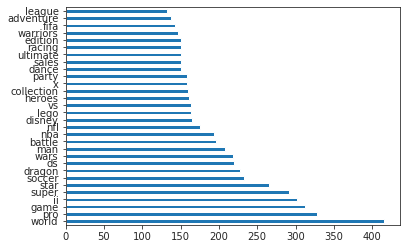

In [19]:
pd.Series(words).value_counts().head(30).plot(kind="barh")

In [20]:
from nltk.util import ngrams

def line_ngram(line, n=2):
    words = [w for w in line.split(' ') if len(w) != 0] # 空文字は取り除く
    return list(ngrams(words, n))

In [21]:
name_grams = names.map(line_ngram)

In [22]:
train["Name"][0]

'LEGO Batman: The Videogame'

In [23]:
name_grams[0]

[('lego', 'batman'), ('batman', 'videogame')]

In [24]:
grams = [x for row in name_grams for x in row if len(x) > 0]
pd.Series(grams).value_counts().head(20)

(star, wars)           123
(madden, nfl)           96
(final, fantasy)        91
(jp, sales)             88
(pro, yakyuu)           88
(tom, clancy)           85
(need, speed)           83
(dragon, ball)          76
(jikkyou, powerful)     70
(fifa, soccer)          70
(harry, potter)         68
(powerful, pro)         66
(spider, man)           66
(pro, evolution)        65
(call, duty)            65
(evolution, soccer)     64
(resident, evil)        63
(mega, man)             60
(pga, tour)             59
(super, robot)          58
dtype: int64

In [25]:
top_grams = pd.Series(grams).value_counts().head(20).index
w = top_grams[0]
name_grams.map(lambda x: w in x).sum()

123

In [26]:
def clean_by_hero(x):
    custom_pipeline = [
        preprocessing.fillna,
        preprocessing.lowercase,
        preprocessing.remove_digits,
        preprocessing.remove_punctuation,
        preprocessing.remove_diacritics,
        preprocessing.remove_whitespace,
        preprocessing.remove_stopwords
    ]
    return hero.clean(x, custom_pipeline)

def create_n_gram(x, n=3):
    x = clean_by_hero(x)
    x = pd.Series(x).map(lambda r: line_ngram(r, n=n))
    return x

class NameGramBlock(BaseBlock):
    def __init__(self, whole_df, n=3):
        self.whole_df = whole_df
        self.n = n
        
    def fit(self, input_df, y=None):
        name_grams = create_n_gram(self.whole_df["Name"], n=self.n)
        grams = [x for row in name_grams for x in row if len(x) > 0]
        top_grams = pd.Series(grams).value_counts().head(20).index
        
        self.top_grams_ = top_grams
        return self.transform(input_df)
    
    def transform(self, input_df):
        name_grams = create_n_gram(input_df["Name"], n=self.n)
        output_df = pd.DataFrame()
        
        for top in self.top_grams_:
            s_top = "-".join(top)
            output_df[f"{s_top}"] = name_grams.map(lambda x: top in x).map(int)
            
        return output_df.add_prefix("Name_has_").add_suffix(f'_n={self.n}')

In [27]:
block = NameGramBlock(train, n=3)
block.fit(train).head()

,Name_has_major-league-baseball_n=3,Name_has_grand-theft-auto_n=3,Name_has_wwe-smackdown-vs_n=3,Name_has_super-robot-taisen_n=3,Name_has_smackdown-vs-raw_n=3,Name_has_shin-megami-tensei_n=3,Name_has_lego-star-wars_n=3,Name_has_dragon-ball-z_n=3,Name_has_katekyoo-hitman-reborn_n=3,Name_has_star-wars-force_n=3,Name_has_romance-three-kingdoms_n=3,Name_has_marvel-super-heroes_n=3,Name_has_pachi-slot-kouryaku_n=3,Name_has_mx-vs-atv_n=3,Name_has_slot-kouryaku-series_n=3,Name_has_lego-harry-potter_n=3,Name_has_hisshou-pachinko-pachi_n=3,Name_has_pachinko-pachi-slot_n=3,Name_has_rock-band-track_n=3,Name_has_band-track-pack_n=3
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


In [28]:
block.transform(test).sum()

/opt/anaconda3/lib/python3.7/site-packages/texthero/preprocessing.py:72: FutureWarning: The default value of regex will change from True to False in a future version.
  return input.str.replace(pattern, symbols)
/opt/anaconda3/lib/python3.7/site-packages/texthero/preprocessing.py:131: FutureWarning: The default value of regex will change from True to False in a future version.
  return input.str.replace(rf"([{string.punctuation}])+", symbol)


Name_has_major-league-baseball_n=3     14
Name_has_grand-theft-auto_n=3           0
Name_has_wwe-smackdown-vs_n=3           1
Name_has_super-robot-taisen_n=3        16
Name_has_smackdown-vs-raw_n=3           1
Name_has_shin-megami-tensei_n=3         1
Name_has_lego-star-wars_n=3             6
Name_has_dragon-ball-z_n=3             24
Name_has_katekyoo-hitman-reborn_n=3     0
Name_has_star-wars-force_n=3            0
Name_has_romance-three-kingdoms_n=3     0
Name_has_marvel-super-heroes_n=3        2
Name_has_pachi-slot-kouryaku_n=3        0
Name_has_mx-vs-atv_n=3                  4
Name_has_slot-kouryaku-series_n=3       0
Name_has_lego-harry-potter_n=3          0
Name_has_hisshou-pachinko-pachi_n=3     0
Name_has_pachinko-pachi-slot_n=3        0
Name_has_rock-band-track_n=3            0
Name_has_band-track-pack_n=3            0
dtype: int64

In [29]:
sales_columns = train.columns[train.columns.str.contains("Sales")].tolist()
sales_columns = sorted(sales_columns)
sales_columns

['EU_Sales', 'Global_Sales', 'JP_Sales', 'NA_Sales', 'Other_Sales']

In [30]:
key = "Genre"
input_df = train
input_df[sales_columns].groupby(input_df[key]).sum()

,EU_Sales,Global_Sales,JP_Sales,NA_Sales,Other_Sales
Genre,,,,,
Action,30483,106343,10165,54010,11610
Adventure,4522,16634,3753,7229,1131
Fighting,5807,27258,5808,13313,2307
Misc,13411,48441,7803,22588,4601
Platform,16573,71149,12114,38119,4320
Puzzle,3871,19153,4497,9849,921
Racing,13039,44301,5026,21745,4465
Role-Playing,13536,72067,29886,24282,4348
Shooter,10890,43028,1964,26631,3506


In [31]:
class SalesPortfolioBlock(BaseBlock):
    """売上ポートフォリオ"""

    def __init__(self, key: str):
        self.key = key    
        self.meta_df = None

    def fit(self, input_df):
        _df = input_df[sales_columns].groupby(input_df[self.key]).sum()
        _df = (_df.T / _df.sum(axis=1)).T
        self.meta_df = _df
        return self.transform(input_df)

    def transform(self, input_df):
        out_df = pd.merge(input_df[self.key], self.meta_df, on=self.key, how='left').drop(columns=[self.key])
        out_df = out_df.add_prefix(f'SP@{self.key}_')
        return out_df

In [32]:
class WrapperBlock(BaseBlock):
    def __init__(self, function):
        self.function = function
        
    def transform(self, input_df):
        return self.function(input_df)

In [33]:
from contextlib import contextmanager
from time import time

@contextmanager
def timer(logger=None, format_str="{:.3f}[s]", prefix=None, suffix=None):
    if prefix:
        format_str = str(prefix) + format_str
    if suffix:
        format_str = format_str + str(suffix)
    start = time()
    yield
    d = time() - start
    out_str = format_str.format(d)
    if logger:
        logger.info(out_str)
    else:
        print(out_str)

In [34]:
process_blocks = [
    WrapperBlock(create_continuous_features),
    WrapperBlock(create_boolean_feature),
    NameGramBlock(whole_df, n=3),
    *[OneHotBlock(c) for c in ['Platform', 'Genre', 'Publisher', 'Rating']],
    *[CountEncodingBlock(c, whole_df=whole_df) for c in ['Name', 'Platform', 'Year_of_Release']],
    *[SalesPortfolioBlock(c) for c in ['Genre']]
]

In [36]:
process_blocks

In [37]:
from tqdm import tqdm


def get_function(block, is_train):
    s = mapping = {
        True: 'fit',
        False: 'transform'
    }.get(is_train)
    return getattr(block, s)


def to_feature(input_df, 
               blocks,
               is_train=False):
    out_df = pd.DataFrame()

    for block in tqdm(blocks, total=len(blocks)):
        func = get_function(block, is_train)

        with timer(prefix='create ' + str(block) + ' '):
            _df = func(input_df)

        assert len(_df) == len(input_df), func.__name__
        out_df = pd.concat([out_df, _df], axis=1)

    return out_df

In [40]:
train_feat_df = to_feature(train, process_blocks, is_train=True)
test_feat_df = to_feature(test, process_blocks)

  0%|          | 0/11 [00:00<?, ?it/s]/opt/anaconda3/lib/python3.7/site-packages/texthero/preprocessing.py:72: FutureWarning: The default value of regex will change from True to False in a future version.
  return input.str.replace(pattern, symbols)
/opt/anaconda3/lib/python3.7/site-packages/texthero/preprocessing.py:131: FutureWarning: The default value of regex will change from True to False in a future version.
  return input.str.replace(rf"([{string.punctuation}])+", symbol)


create <__main__.WrapperBlock object at 0x7fdf7a617350> 0.014[s]
create <__main__.WrapperBlock object at 0x7fdf7a617310> 0.052[s]


  0%|          | 0/11 [00:00<?, ?it/s]

create <__main__.NameGramBlock object at 0x7fdf7a617490> 0.954[s]
create <__main__.OneHotBlock object at 0x7fdf7a617610> 0.010[s]
create <__main__.OneHotBlock object at 0x7fdf7a6175d0> 0.008[s]
create <__main__.OneHotBlock object at 0x7fdf7a617590> 0.012[s]
create <__main__.OneHotBlock object at 0x7fdf7a617790> 0.008[s]
create <__main__.CountEncodingBlock object at 0x7fdf7a617750> 0.016[s]
create <__main__.CountEncodingBlock object at 0x7fdf7a6178d0> 0.009[s]
create <__main__.CountEncodingBlock object at 0x7fdf7a617850> 0.004[s]
create <__main__.SalesPortfolioBlock object at 0x7fdf7a6177d0> 0.010[s]
create <__main__.WrapperBlock object at 0x7fdf7a617350> 0.012[s]
create <__main__.WrapperBlock object at 0x7fdf7a617310> 0.044[s]


/opt/anaconda3/lib/python3.7/site-packages/texthero/preprocessing.py:72: FutureWarning: The default value of regex will change from True to False in a future version.
  return input.str.replace(pattern, symbols)
/opt/anaconda3/lib/python3.7/site-packages/texthero/preprocessing.py:131: FutureWarning: The default value of regex will change from True to False in a future version.
  return input.str.replace(rf"([{string.punctuation}])+", symbol)
100%|██████████| 11/11 [00:00<00:00, 12.33it/s]

create <__main__.NameGramBlock object at 0x7fdf7a617490> 0.742[s]
create <__main__.OneHotBlock object at 0x7fdf7a617610> 0.005[s]
create <__main__.OneHotBlock object at 0x7fdf7a6175d0> 0.006[s]
create <__main__.OneHotBlock object at 0x7fdf7a617590> 0.006[s]
create <__main__.OneHotBlock object at 0x7fdf7a617790> 0.005[s]
create <__main__.CountEncodingBlock object at 0x7fdf7a617750> 0.020[s]
create <__main__.CountEncodingBlock object at 0x7fdf7a6178d0> 0.010[s]
create <__main__.CountEncodingBlock object at 0x7fdf7a617850> 0.004[s]
create <__main__.SalesPortfolioBlock object at 0x7fdf7a6177d0> 0.005[s]


In [41]:
test_feat_df.head().T

,0,1,2,3,4
Critic_Score,84.000000,91.000000,87.000000,70.000000,71.000000
Critic_Count,23.000000,17.000000,28.000000,54.000000,41.000000
User_Score,8.000000,9.000000,8.500000,6.900000,6.900000
User_Count,19.000000,132.000000,39.000000,180.000000,143.000000
Year_of_Release,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...
SP@Genre_EU_Sales,0.143375,0.143375,0.143375,0.143375,0.143375
SP@Genre_Global_Sales,0.500176,0.500176,0.500176,0.500176,0.500176
SP@Genre_JP_Sales,0.047810,0.047810,0.047810,0.047810,0.047810
SP@Genre_NA_Sales,0.254032,0.254032,0.254032,0.254032,0.254032


In [42]:
assert len(test_feat_df) == len(test)

In [43]:
import lightgbm as lgbm
import xgboost as xgb

from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import mean_squared_error

def fit_lgbm(X, 
             y, 
             cv, 
             params: dict=None, 
             verbose: int=50):
    """lightGBM を CrossValidation の枠組みで学習を行なう function"""
    metric_func = mean_squared_error

    # パラメータがないときは、空の dict で置き換える
    if params is None:
        params = {}

    models = []
    # training data の target と同じだけのゼロ配列を用意
    # float にしないと悲しい事件が起こるのでそこだけ注意
    oof_pred = np.zeros_like(y, dtype=np.float)

    for i, (idx_train, idx_valid) in enumerate(cv): 
        # この部分が交差検証のところです。データセットを cv instance によって分割します
        # training data を trian/valid に分割
        x_train, y_train = X[idx_train], y[idx_train]
        x_valid, y_valid = X[idx_valid], y[idx_valid]

        clf = lgbm.LGBMRegressor(**params)

        with timer(prefix='fit fold={} '.format(i + 1)):
            clf.fit(x_train, y_train, 
                    eval_set=[(x_valid, y_valid)],  
                    early_stopping_rounds=verbose,
                    verbose=verbose)

        pred_i = clf.predict(x_valid)

        oof_pred[idx_valid] = pred_i
        models.append(clf)

        print(f'Fold {i} RMSLE: {metric_func(y_valid, pred_i) ** .5:.4f}')

    score = metric_func(y, oof_pred) ** .5
    print('FINISHED | Whole RMSLE: {:.4f}'.format(score))
    return oof_pred, models

In [44]:
params = {
    'objective': 'rmse', # 目的関数. これの意味で最小となるようなパラメータを探します. 
    'learning_rate': .1, # 学習率. 小さいほどなめらかな決定境界が作られて性能向上に繋がる場合が多いです、がそれだけ木を作るため学習に時間がかかります
    'max_depth': 6, # 木の深さ. 深い木を許容するほどより複雑な交互作用を考慮するようになります
    'n_estimators': 10000, # 木の最大数. early_stopping という枠組みで木の数は制御されるようにしていますのでとても大きい値を指定しておきます.
    'colsample_bytree': .5, # 木を作る際に考慮する特徴量の割合. 1以下を指定すると特徴をランダムに欠落させます。小さくすることで, まんべんなく特徴を使うという効果があります.
    'importance_type': 'gain' # 特徴重要度計算のロジック(後述)
}

y = train['Global_Sales'].values
y = np.log1p(y) # log + plus1 変換する

In [45]:
from sklearn.model_selection import KFold, GroupKFold

fold = KFold(n_splits=5, shuffle=True, random_state=0)
cv = list(fold.split(train_feat_df, y))

In [46]:
oof, models = fit_lgbm(train_feat_df.values, y, cv, params=params)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
Training until validation scores don't improve for 50 rounds
[50]	valid_0's rmse: 0.917657
[100]	valid_0's rmse: 0.8868
[150]	valid_0's rmse: 0.874355
[200]	valid_0's rmse: 0.869963
[250]	valid_0's rmse: 0.867362
[300]	valid_0's rmse: 0.866317
Early stopping, best iteration is:
[261]	valid_0's rmse: 0.865527
fit fold=1 0.430[s]
Fold 0 RMSLE: 0.8655
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
Training until validation scores don't improve for 50 rounds
[50]	valid_0's rmse: 0.942574
[100]	valid_0's rmse: 0.906261
[150]	valid_0's rmse: 0.892944
[200]	valid_0's rmse: 0.885862
[250]	valid_0's rmse: 0.883002
[300]	valid_0's rmse: 0.882745
[350]	valid_0's rmse: 0.881255
[400]	valid_0's rmse: 0.881577
Early stopping, best iteration is:
[374]	valid_0's rmse: 0.880714
fit fold=2 0.75

In [47]:
def split_by_groups(groups):
    kfold = KFold(n_splits=10, random_state=0, shuffle=True)
    groups = pd.Series(groups)
    
    unique_groups = groups.unique()
    splits = []
    
    def _filter_ids(idx):
        values = unique_groups[idx]
        idx = groups.isin(values)
        return groups[idx].index.values
    
    for idx_tr, idx_val, in kfold.split(unique_groups):
        splits.append([
            _filter_ids(idx_tr), _filter_ids(idx_val)
        ])
        
    return splits

In [49]:
def visualize_importance(models, feat_train_df):
    """lightGBM の model 配列の feature importance を plot する
    CVごとのブレを boxen plot として表現します.

    args:
        models:
            List of lightGBM models
        feat_train_df:
            学習時に使った DataFrame
    """
    feature_importance_df = pd.DataFrame()
    for i, model in enumerate(models):
        _df = pd.DataFrame()
        _df['feature_importance'] = model.feature_importances_
        _df['column'] = feat_train_df.columns
        _df['fold'] = i + 1
        feature_importance_df = pd.concat([feature_importance_df, _df], axis=0, ignore_index=True)

    order = feature_importance_df.groupby('column')\
        .sum()[['feature_importance']]\
        .sort_values('feature_importance', ascending=False).index[:50]

    fig, ax = plt.subplots(figsize=(max(6, len(order) * .4), 7))
    sns.boxenplot(data=feature_importance_df, x='column', y='feature_importance', order=order, ax=ax, palette='viridis')
    ax.tick_params(axis='x', rotation=90)
    ax.grid()
    fig.tight_layout()
    return fig, ax

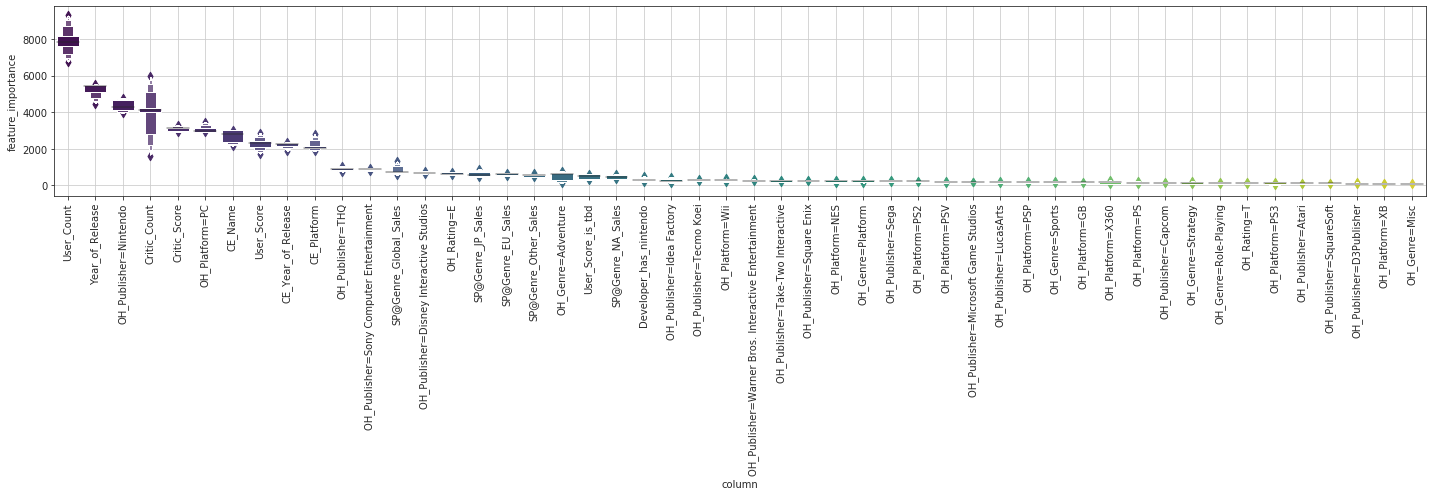

In [50]:
fig, ax = visualize_importance(models, train_feat_df)

In [51]:
pred = np.array([model.predict(test_feat_df.values) for model in models])
pred = np.mean(pred, axis=0)
pred = np.expm1(pred)
pred = np.where(pred < 0, 0, pred)

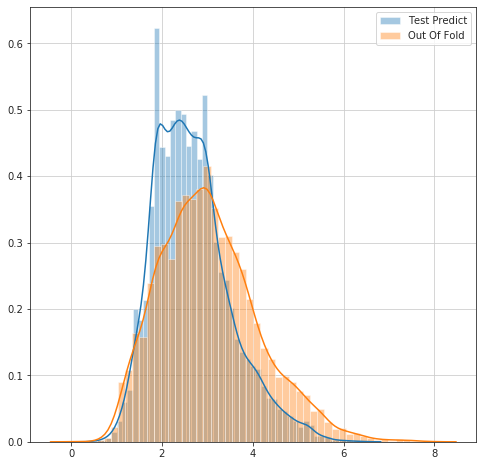

In [52]:
fig, ax = plt.subplots(figsize=(8, 8))
sns.distplot(np.log1p(pred), label='Test Predict')
sns.distplot(oof, label='Out Of Fold')
ax.legend()
ax.grid()

In [53]:
sub_df = pd.DataFrame({ 'Global_Sales': pred })
sub_df.to_csv(os.path.join(OUTPUT, 'submit_copy.csv'), index=False)